# Sales volume time series with ARIMA

Guess Mercadona wants to know the Sales volume for the next 30 days, and also wants to compare the sales with two competitor supermarkets.

Dates: From March 6th, 2021 to November 30th,2022.
website: https://datamarket.es/dashboards?slug=productos-de-supermercados

Dataset information:
3 online supermarkets in Spain: Dia, Carrefour, Mercadona


Features:
category: Categoría del producto.
description: Información adicional del producto (formato de empaquetado, etc.).
insert_date: Fecha de extracción de la información.
name: Nombre del producto.
price: Precio absoluto del producto en €. En caso de existir algún tipo de descuento aparecerá el menor precio disponible.
reference_price: Precio unitario (por unidad de medida del producto, €/Kg, €/L, etc.).
reference_unit: Unidad de referencia del producto (Kg, L, etc.).
supermarket: Supermercado al que pertenece el producto.

# 1. Import libraries and understand the data

In [58]:
#Exploring data
import pandas as pd
import numpy as np
from datetime import timedelta
from collections import Counter

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline


In [59]:
raw_data = pd.read_csv(r"/Users/liss/Documents/GitHub/Sales-volume-forecast-ARIMA/datamarket_productos_de_supermercados.csv", encoding="UTF8")
raw_data.tail()

,url,supermarket,category,name,description,price,reference_price,reference_unit,insert_date,product_id
9067728,https://www.dia.es/compra-online/cuidado-perso...,dia-es,cuidado_personal_bano_e_higiene_personal_champus,HS champú anticaspa menthol fresh bote 230 ml,NaN,3.19,13.87,l,2022-11-17 00:00:00,6b283350affe823c96c3af9d18953251
9067729,https://www.dia.es/compra-online/bebidas/aguas...,dia-es,bebidas_aguas,AQUAREL agua mineral natural botella 5 lt,NaN,1.49,0.30,l,2022-11-17 00:00:00,bd1ac576497a39f69cdf2462b015314f
9067730,https://www.dia.es/compra-online/bebidas/aguas...,dia-es,bebidas_aguas,FONT VELLA Levite limón botella 1.25 lt,NaN,1.65,1.32,l,2022-11-17 00:00:00,0ecdc59cb9677f54e1e1f28b0c8e0a7f
9067731,https://tienda.mercadona.es/product/3267/pera-...,mercadona-es,fruta_y_verdura_fruta,Pera Rocha,Pieza,0.28,2.19,kg,2022-11-17 00:00:00,3816000deedf53985ade236da2e878df
9067732,https://www.dia.es/compra-online/bebidas/aguas...,dia-es,bebidas_aguas,AQUABONA agua mineral natural botella 5 lt,NaN,1.29,0.26,l,2022-11-17 00:00:00,4070e21a09c737626f0ef259d57e2680


In [60]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9067733 entries, 0 to 9067732
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   url              object 
 1   supermarket      object 
 2   category         object 
 3   name             object 
 4   description      object 
 5   price            float64
 6   reference_price  float64
 7   reference_unit   object 
 8   insert_date      object 
 9   product_id       object 
dtypes: float64(2), object(8)
memory usage: 691.8+ MB


### Digging into the data

This model only needs price and number of products, some features or columns will be removed

In [61]:
#nan on price will be filled consequently if needed
raw_data.isnull().sum()

url                      0
supermarket              0
category                 0
name                   231
description        5744317
price                   18
reference_price          6
reference_unit        5480
insert_date              0
product_id               0
dtype: int64

In [62]:
raw_data[raw_data['price'].isnull()]

,url,supermarket,category,name,description,price,reference_price,reference_unit,insert_date,product_id
6358138,https://www.carrefour.es/supermercado/limon-a-...,carrefour-es,productos_frescos_frutas_naranjas_y_otros_citr...,Limón a granel 1 Kg aprox,NaN,NaN,2.29,kg,2022-05-06 00:00:00,21db945fe921f68bc2fc6940a7372d19
7106312,https://www.dia.es/compra-online/despensa/past...,dia-es,despensa_pastas_harinas_y_masas_pastas,DIA SELECCIÓN MUNDIAL tortiglioni paquete 500 gr,NaN,NaN,NaN,NaN,2022-06-27 00:00:00,61a283804a2289fbe661250c83c1a717
7108434,https://www.dia.es/compra-online/despensa/lact...,dia-es,despensa_lacteos_y_huevos_mantequilla_y_margarina,DIA margarina ligera barqueta 500 gr,NaN,NaN,NaN,NaN,2022-06-27 00:00:00,65f083cea3dd8750f4738e187ec0dbc4
7108873,https://www.dia.es/compra-online/despensa/desa...,dia-es,despensa_desayunos_y_dulces_bolleria,BISCUITS GALICIA mini magdalenas con mantequil...,NaN,NaN,NaN,NaN,2022-06-27 00:00:00,d522a411cc1cc234dd353d4f14380733
7114222,https://www.dia.es/compra-online/despensa/lact...,dia-es,despensa_lacteos_y_huevos_mantequilla_y_margarina,DIA margarina ligera barqueta 500 gr,NaN,NaN,NaN,NaN,2022-06-28 00:00:00,65f083cea3dd8750f4738e187ec0dbc4
7114662,https://www.dia.es/compra-online/despensa/past...,dia-es,despensa_pastas_harinas_y_masas_pastas,DIA SELECCIÓN MUNDIAL tortiglioni paquete 500 gr,NaN,NaN,NaN,NaN,2022-06-28 00:00:00,61a283804a2289fbe661250c83c1a717
7121216,https://www.dia.es/compra-online/despensa/desa...,dia-es,despensa_desayunos_y_dulces_bolleria,BISCUITS GALICIA mini magdalenas con mantequil...,NaN,NaN,NaN,NaN,2022-06-28 00:00:00,d522a411cc1cc234dd353d4f14380733
7280479,https://www.carrefour.es/supermercado/ginebra-...,carrefour-es,bebidas_alcoholes_ginebra,Ginebra Gordon's 1 l.,NaN,NaN,13.49,l,2022-07-09 00:00:00,4dfc046c75551b4d2324070e00ae2a49
7388015,https://www.carrefour.es/supermercado/whisky-j...,carrefour-es,bebidas_alcoholes_todos_los_alcoholes,Whisky Jameson irlandés 70 cl.,NaN,NaN,25.99,l,2022-07-17 00:00:00,c09040febafa3b18253fa796df590548
7399970,https://www.carrefour.es/supermercado/whisky-j...,carrefour-es,bebidas_alcoholes_todos_los_alcoholes,Whisky Jameson irlandés 70 cl.,NaN,NaN,25.99,l,2022-07-18 00:00:00,c09040febafa3b18253fa796df590548


In [63]:
#outliers? , it seems max is 7999, check it, it may be an error or an outlier
raw_data.describe()

,price,reference_price
count,9.067715e+06,9.067727e+06
mean,4.764327e+00,1.886243e+01
std,4.832522e+01,6.013926e+02
min,8.000000e-02,3.000000e-03
25%,1.390000e+00,1.830000e+00
50%,2.250000e+00,4.590000e+00
75%,3.990000e+00,9.940000e+00
max,7.915050e+03,1.633333e+05


Deal with outliers

In [64]:
# the most expensive fruit or veggie cost 7€, just in case, it is set in 8. It seems everything is multiplied by 100!! and only in mercadona supermarket!.
raw_data['price'] = np.where((raw_data['price'] >= 490.05) &
                             (raw_data['supermarket']=='mercadona-es') |
                             ((raw_data['category'] == 'fruta_y_verdura_verdura') & (raw_data['price']>= 8.0)) |
                             ((raw_data['category'] == 'fruta_y_verdura_fruta') & (raw_data['price']>= 8.0)),
                             round(raw_data['price']/100,2), raw_data['price'].values)

#raw_data.sort_values(by='price')

In [65]:
raw_data['insert_date'] = pd.to_datetime(raw_data['insert_date']).dt.normalize()

#insert_date is the date of the day after the sale
raw_data['daily_sales'] = raw_data['insert_date']- timedelta(days=1)

raw_data['unit']= int(1)

In [66]:
raw_data = raw_data.drop(['url', 'category', 'description', 'reference_price', 'reference_unit', 'insert_date', 'product_id'], axis=1)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9067733 entries, 0 to 9067732
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   supermarket  object        
 1   name         object        
 2   price        float64       
 3   daily_sales  datetime64[ns]
 4   unit         int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 345.9+ MB


# 2. Compare sales among the supermarkets

Split data of the different supermarkets

In [67]:
raw_data_carre = raw_data[raw_data['supermarket']=='carrefour-es']
raw_data_dia = raw_data[raw_data['supermarket']=='dia-es']
raw_data_merca = raw_data[raw_data['supermarket']=='mercadona-es']

In [68]:
raw_data_carre = raw_data_carre.drop(['supermarket'], axis=1)
raw_data_dia = raw_data_dia.drop(['supermarket'], axis=1)
raw_data_merca = raw_data_merca.drop(['supermarket'], axis=1)


In [69]:
# Make copies for the modeling
rmodelCarre= raw_data_carre.copy()
rmodelDia = raw_data_dia.copy()
rmodelMerca = raw_data_merca.copy()

In [70]:
# Number of products and total sales
print("Carrefour's number of products sold: ", raw_data_carre.shape[0], ", total sales(€): ","",round(raw_data_carre['price'].sum(),2))
print("Dia's number of products sold: ", raw_data_dia.shape[0], ", \ttotal sales(€): ",round(raw_data_dia['price'].sum(),2))
print("Mercadona's number of products sold: ", raw_data_merca.shape[0], ", total sales(€): ",round(raw_data_merca['price'].sum(),2))

#Carrefour vs Mercadona vs Dia volumen
print("\nDifference on number of products between Mercadona and Carrefour: ", raw_data_merca.shape[0] - raw_data_carre.shape[0])
print("Difference on number of products between Mercadona and Dia: ", raw_data_merca.shape[0] - raw_data_dia.shape[0])
print("Difference on total sales between Mercadona and Carrefour(€): ", round(raw_data_merca['price'].sum() - raw_data_carre['price'].sum(),2))
print("Difference on total sales between Mercadona and Dia(€): ", round(raw_data_merca['price'].sum() - raw_data_dia['price'].sum(),2))
#Dia earns more than Mercadona

Carrefour's number of products sold:  1870589 , total sales(€):   9465631.31
Dia's number of products sold:  3532982 , 	total sales(€):  12033125.56
Mercadona's number of products sold:  3664162 , total sales(€):  11900226.84

Difference on number of products between Mercadona and Carrefour:  1793573
Difference on number of products between Mercadona and Dia:  131180
Difference on total sales between Mercadona and Carrefour(€):  2434595.53
Difference on total sales between Mercadona and Dia(€):  -132898.72


### Check out the most expensive products by supermarket

In [71]:
raw_data_carre_expensive= raw_data_carre.groupby('name').sum()
rd_carre_expensive = raw_data_carre_expensive.sort_values('price', ascending=False)[:5]

raw_data_dia_expensive= raw_data_dia.groupby('name').sum()
rd_dia_expensive = raw_data_dia_expensive.sort_values('price', ascending=False)[:5]

raw_data_merca_expensive= raw_data_merca.groupby('name').sum()
rd_merca_expensive = raw_data_merca_expensive.sort_values('price', ascending=False)[:5]

print("Carrefour most expensive products: \n", rd_carre_expensive, end="\n\n")
print("\nDia most expensive products: \n", rd_dia_expensive, end="\n\n")
print("\nMercadona most expensive products: \n", rd_merca_expensive)

Carrefour most expensive products: 
                                                       price  unit
name                                                             
Jamón de cebo ibérico 50% raza ibérica Legado I...  69129.0   525
Jamón de bellota ibérico 100% raza ibérica piez...  54032.0   148
Jamón curado reserva 4 estaciones Navidul pieza...  37072.0   566
Paleta de bellota ibérica 100% raza ibérica pie...  36232.0   178
Jamón de cebo ibérico 50% raza ibérica pieza de...  32755.0   286


Dia most expensive products: 
                                                       price  unit
name                                                             
NOBLEZA EXTREMEÑA jamón de bellota 100% ibérico...  65025.0   225
LEGADO jamón de cebo Ibérico 50% raza ibérica p...  63608.0   528
SÁNCHEZ ALCARAZ jamón de cebo Ibérico 50% pieza...  60900.8   542
CANPIPORK jamón de cebo Ibérico 50% raza ibéric...  43079.0   397
MANUEL DE MONTEJO jamón de cebo Ibérico 50% pie...  40593.0   367


Merc

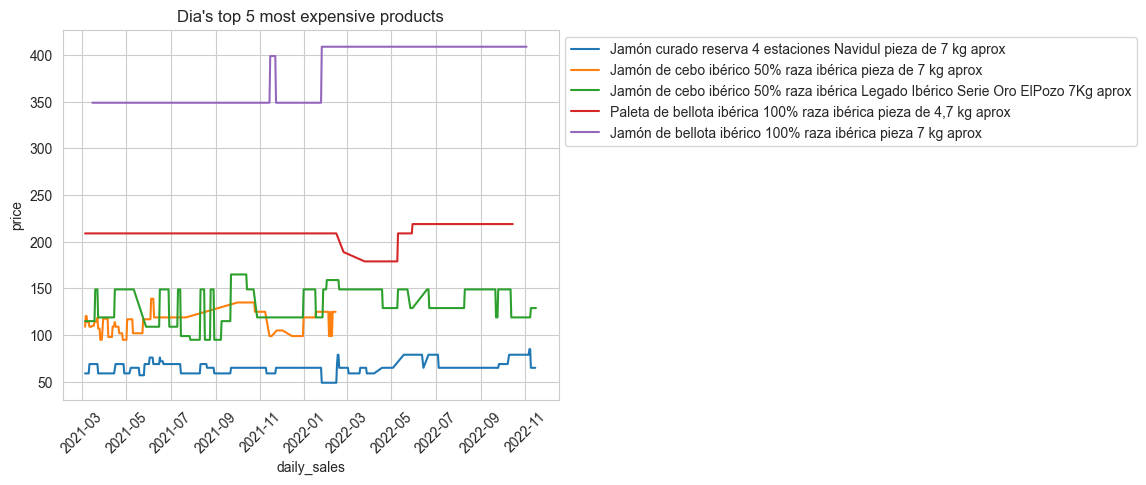

In [72]:
#Top 5 most expensive items
los5ExCarre= list(rd_carre_expensive.index)
Carre5Ex = pd.DataFrame(raw_data_carre[raw_data_carre.name.isin(los5ExCarre)])
Carre5Ex['price'].dropna()
Carre5Ex=Carre5Ex.loc[:,['daily_sales', 'name', 'price', 'unit']]

#Visualization
sns.set_style('whitegrid')
ax = sns.lineplot(data= Carre5Ex, x='daily_sales',
             y ='price', hue='name', err_style=None)
legend = plt.legend(fontsize = '9')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Dia's top 5 most expensive products")
plt.xticks(rotation=45)
plt.show();

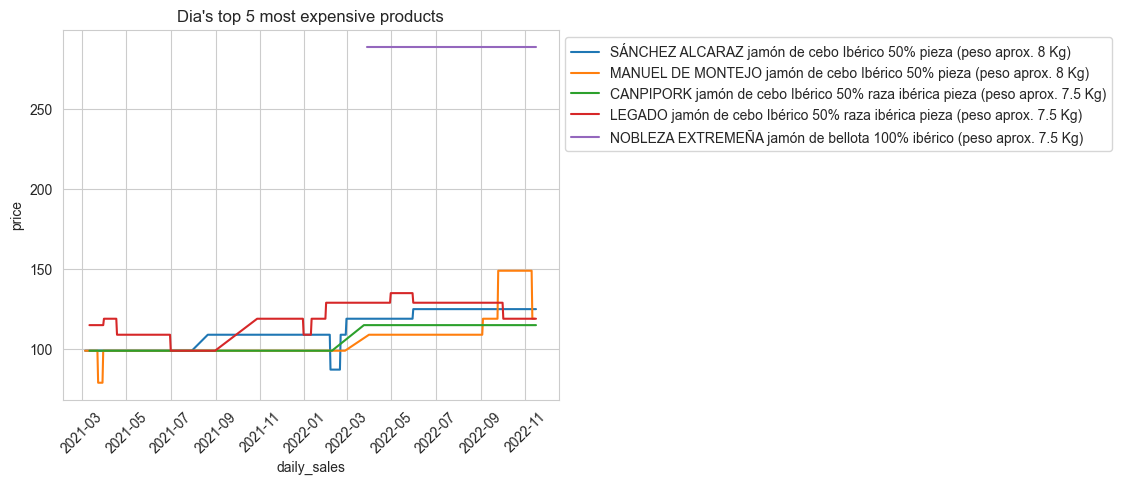

In [73]:
los5ExDia= list(rd_dia_expensive.index)
Dia5Ex = pd.DataFrame(raw_data_dia[raw_data_dia.name.isin(los5ExDia)])
Dia5Ex['price'].dropna()
Dia5Ex=Dia5Ex.loc[:,['daily_sales', 'name', 'price', 'unit']]

#Visualization
sns.set_style('whitegrid')
ax = sns.lineplot(data= Dia5Ex, x='daily_sales',
             y ='price', hue='name', err_style=None)
plt.title("Dia's top 5 most expensive products")
plt.xticks(rotation=45)
legend = plt.legend(fontsize = '9')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show();

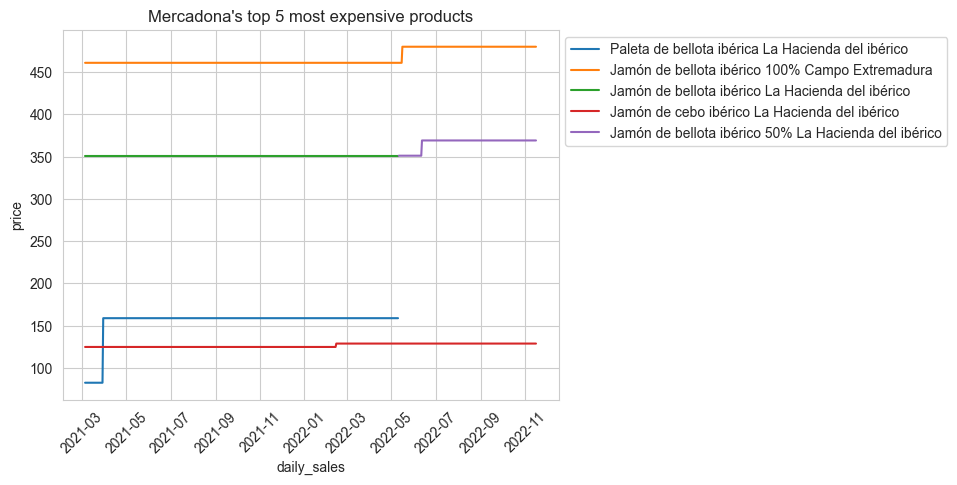

In [74]:
los5ExMerca= list(rd_merca_expensive.index)
Merca5Ex = pd.DataFrame(raw_data_merca[raw_data_merca.name.isin(los5ExMerca)])
Merca5Ex=Merca5Ex.loc[:,['daily_sales', 'name', 'price', 'unit']]

#Visualization
sns.set_style('whitegrid')
ax = sns.lineplot(data= Merca5Ex, x='daily_sales',
             y ='price', hue='name', err_style=None)
legend = plt.legend(fontsize = '9')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Mercadona's top 5 most expensive products")
plt.xticks(rotation=45)
plt.show();

### Check out the most sold products

In [75]:
#count the 5 products most bought among all supermarkets
prod_most_commonCarre5 = Counter(raw_data_carre['name']).most_common(5)
prod_most_commonDia5 = Counter(raw_data_dia['name']).most_common(5)
prod_most_commonMerca5 = Counter(raw_data_merca['name']).most_common(5)

most_commonCarre5 = pd.DataFrame(prod_most_commonCarre5, columns= ['Carrefour most sold', 'Units'])
most_commonDia5 = pd.DataFrame(prod_most_commonDia5, columns= ['Dia most sold', 'Units'])
most_commonMerca5 = pd.DataFrame(prod_most_commonMerca5, columns= ['Mercadona Most sold', 'Units'])
print(most_commonCarre5, most_commonDia5, most_commonMerca5, sep='\n\n')

                                 Carrefour most sold  Units
0                              Vodka Vikoroff 70 cl.   1000
1            Conos con helado de nata Cornetto 6 ud.    898
2              Bombilla Led Estándar Philips 60W E27    779
3  Crema fijadora para prótesis dentales Corega 7...    724
4             Bálsamo labial hidratante Carmex 1 ud.    701

                                       Dia most sold  Units
0  INSTITUTO ESPAÑOL agua de colonia gotas fresca...   1234
1      SANEX desodorante natur protect roll on 50 ml   1121
2       SANEX desodorante natur protect spray 200 ml   1019
3             DIA cocktail frutos secos bolsa 500 gr    809
4          BONTE desodorante attraction spray 150 ml    761

              Mercadona Most sold  Units
0       Cerveza Clásica Steinburg   5565
1              Refresco Coca-Cola   4354
2  Refresco Coca-Cola Zero azúcar   4217
3      Cerveza Especial Steinburg   4067
4         Refresco cola Hacendado   3110


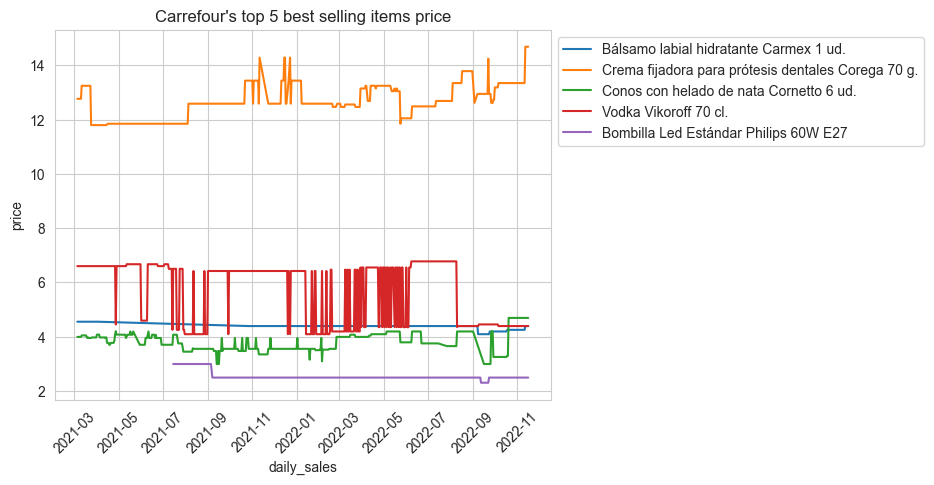

In [76]:
#Top 5 best selling items
los5C= list(most_commonCarre5.iloc[:,0])
Carre5 = pd.DataFrame(raw_data_carre[raw_data_carre.name.isin(los5C)])
Carre5['price'].dropna()
Carre5=Carre5.loc[:,['daily_sales', 'name', 'price', 'unit']]

#Visualization
sns.set_style('whitegrid')
ax = sns.lineplot(data= Carre5, x='daily_sales',
             y ='price', hue='name', err_style=None)
legend = plt.legend(fontsize = '9')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Carrefour's top 5 best selling items price")
plt.xticks(rotation=45)
plt.show();

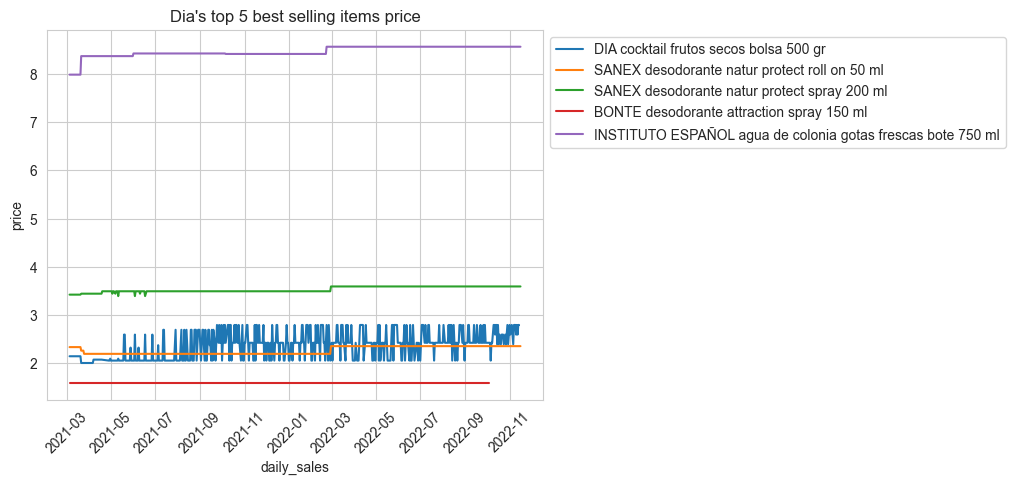

In [77]:
#Top 5 best selling items
los5D= list(most_commonDia5.iloc[:,0])
Dia5 = pd.DataFrame(raw_data_dia[raw_data_dia.name.isin(los5D)])
Dia5['price'].dropna()
Dia5=Dia5.loc[:,['daily_sales', 'name', 'price', 'unit']]

#Visualization
sns.set_style('whitegrid')
ax = sns.lineplot(data= Dia5, x='daily_sales',
             y ='price', hue='name', err_style=None)
legend = plt.legend(fontsize = '9')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Dia's top 5 best selling items price")
plt.xticks(rotation=45)
plt.show();

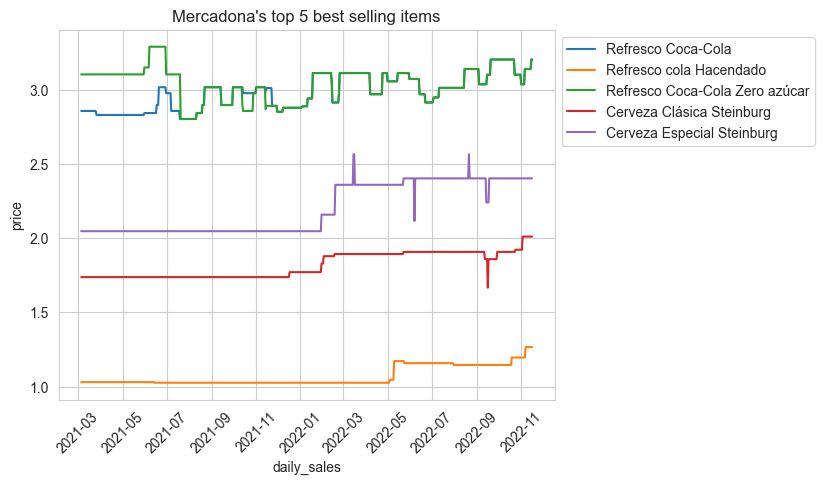

In [78]:
los5M= list(most_commonMerca5.iloc[:,0])
Merca5 = pd.DataFrame(raw_data_merca[raw_data_merca.name.isin(los5M)])
Merca5['price'].dropna()
Merca5=Merca5.loc[:,['daily_sales','name', 'price', 'unit']]
#Visualization
sns.set_style('whitegrid')
ax = sns.lineplot(data= Merca5, x='daily_sales',
             y ='price', hue='name', err_style=None)
legend = plt.legend(fontsize = '9')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Mercadona's top 5 best selling items")
plt.xticks(rotation=45)
plt.show();

### Check out monthly sales evolution of the supermarkets

Carrefour monthly sales evolution

In [79]:
Carre5_oct = Carre5.set_index("daily_sales")
Carre5_oct= Carre5_oct.rename_axis("monthly_sales")

In [80]:
Carre5_oct1= Carre5_oct.groupby([pd.Grouper(freq='M'),'name']).sum()
Carre5_oct1 =Carre5_oct1.rename(columns={'price':'sales'})
Carre5_oct1

sales  unit
monthly_sales name                                                            
2021-03-31    Bálsamo labial hidratante Carmex 1 ud.              222.95    49
              Conos con helado de nata Cornetto 6 ud.             187.78    47
              Crema fijadora para prótesis dentales Corega 70 g.  343.27    27
              Vodka Vikoroff 70 cl.                               356.40    54
2021-04-30    Bálsamo labial hidratante Carmex 1 ud.               18.20     4
...                                                                  ...   ...
2022-11-30    Bombilla Led Estándar Philips 60W E27                72.21    29
              Bálsamo labial hidratante Carmex 1 ud.              128.90    30
              Conos con helado de nata Cornetto 6 ud.              37.52     8
              Crema fijadora para prótesis dentales Corega 70 g.  355.14    26
              Vodka Vikoroff 70 cl.                                65.85    15

[96 rows x 2 columns]

In [81]:
#M1 one month
df = px.data.stocks()
fig= px.line(Carre5_oct1, x=Carre5_oct1.index.get_level_values(0), y='sales', color=Carre5_oct1.index.get_level_values(1))
fig.update_xaxes(dtick='M1', tickformat = '%b\n%Y')
fig.update_layout(showlegend= True, xaxis_title= None, yaxis_title="Sales (€)",
                  title={
        'text': 'Carrefour monthly sales',
        'y':0.95,
        'x':0.53,
        'xanchor': 'center',
        'yanchor': 'top'},
    legend=dict(
    yanchor="top", y=1.35,
    xanchor="left", x=0.01,
    title = 'Items',
    font=dict(size=8)
))
fig.show()
#fig.write_html("data/Carre_month_sales.html")

Dia monthly sales evolution

In [82]:
Dia5_oct = Dia5.copy()
Dia5_oct = Dia5_oct.set_index("daily_sales")
Dia5_oct = Dia5_oct.rename_axis("monthly_sales")

Dia5_oct1 = Dia5_oct.groupby([pd.Grouper(freq='M'), 'name']).sum()
Dia5_oct1 = Dia5_oct1.rename(columns={'price': 'sales'})
Dia5_oct1

sales  unit
monthly_sales name                                                            
2021-03-31    BONTE desodorante attraction spray 150 ml            76.32    48
              DIA cocktail frutos secos bolsa 500 gr              112.48    54
              INSTITUTO ESPAÑOL agua de colonia gotas frescas...  439.93    54
              SANEX desodorante natur protect roll on 50 ml       169.58    74
              SANEX desodorante natur protect spray 200 ml        185.12    54
...                                                                  ...   ...
2022-10-31    SANEX desodorante natur protect spray 200 ml        222.58    62
2022-11-30    DIA cocktail frutos secos bolsa 500 gr               45.43    17
              INSTITUTO ESPAÑOL agua de colonia gotas frescas...  274.24    32
              SANEX desodorante natur protect roll on 50 ml        75.20    32
              SANEX desodorante natur protect spray 200 ml        114.88    32

[104 rows x 2 columns]

In [83]:
df = px.data.stocks()
fig= px.line(Dia5_oct1, x=Dia5_oct1.index.get_level_values(0), y='sales', color=Dia5_oct1.index.get_level_values(1))
fig.update_xaxes(dtick='M1', tickformat = '%b\n%Y')
fig.update_layout(showlegend= True,
                  xaxis_title= None, yaxis_title="Sales (€)",
                  title={
        'text': 'Dia monthly sales',
        'y':0.95,
        'x':0.53,
        'xanchor': 'center',
        'yanchor': 'top'},
    legend=dict(
    yanchor="top", y=1.55,
    xanchor="left", x=0.01,
    title = 'Items',
    font=dict(size=8)
))
fig.show()
#fig.write_html("data/Dia_month_sales.html")

Mercadona monthly sales evolution

In [84]:
Merca5_oct = Merca5.copy()
Merca5_oct = Merca5_oct.set_index("daily_sales")
Merca5_oct = Merca5_oct.rename_axis("monthly_sales")
Merca5_oct1 = Merca5_oct.groupby([pd.Grouper(freq='M'), 'name']).sum()
Merca5_oct1 = Merca5_oct1.rename(columns={'price': 'sales'})
Merca5_oct1

sales  unit
monthly_sales name                                        
2021-03-31    Cerveza Clásica Steinburg       422.55   243
              Cerveza Especial Steinburg      387.18   189
              Refresco Coca-Cola              539.40   189
              Refresco Coca-Cola Zero azúcar  503.28   162
              Refresco cola Hacendado         139.05   135
...                                              ...   ...
2022-11-30    Cerveza Clásica Steinburg       288.16   144
              Cerveza Especial Steinburg      230.88    96
              Refresco Coca-Cola              349.30   112
              Refresco Coca-Cola Zero azúcar  349.30   112
              Refresco cola Hacendado          99.18    80

[105 rows x 2 columns]

In [85]:
df = px.data.stocks()
fig= px.line(Merca5_oct1, x=Merca5_oct1.index.get_level_values(0), y='sales', color=Merca5_oct1.index.get_level_values(1))
fig.update_xaxes(dtick='M1', tickformat = '%b\n%Y')
fig.update_layout(showlegend= True,
                  xaxis_title= None, yaxis_title="Sales (€)",
                  title={
        'text': 'Mercadona monthly sales',
        'y':0.95,
        'x':0.53,
        'xanchor': 'center',
        'yanchor': 'top'},
    legend=dict(
    yanchor="top", y=1.55,
    xanchor="left", x=0.01,
    title = 'Items',
    font=dict(size=8)
))
fig.show()
#fig.write_html("data/Mercadona_month_sales.html")

## 4. Compare daily, weekly and monthly sales among supermarkets

daily sales

In [86]:
raw_data_carre.set_index('daily_sales', inplace=True)
raw_data_dia.set_index('daily_sales', inplace=True)
raw_data_merca.set_index('daily_sales', inplace=True)

In [87]:
dailyCarre = raw_data_carre['price'].resample('D').sum()
dailyDia = raw_data_dia['price'].resample('D').sum()
dailyMerca = raw_data_merca['price'].resample('D').sum()

In [88]:
dailyComparatives = pd.concat([dailyCarre,dailyDia,dailyMerca], join='inner', axis=1)
dailyComparatives.columns =['Carrefour sales', 'Dia sales', 'Mercadona sales']
dailyComparatives = dailyComparatives.rename_axis('daily_sales')
dailyComparatives

,Carrefour sales,Dia sales,Mercadona sales
daily_sales,,,
2021-03-05,34665.54,24797.77,19608.53
2021-03-06,34649.46,24950.92,19543.77
2021-03-07,34805.02,24715.95,19576.10
2021-03-08,34751.49,24866.39,19592.61
2021-03-09,33989.38,24701.35,19393.84
...,...,...,...
2022-11-12,17048.31,18433.28,18758.75
2022-11-13,16949.82,18378.29,18756.34
2022-11-14,17566.90,18449.29,18869.38


weekly sales

In [89]:
by_weekday = dailyComparatives.groupby(dailyComparatives.index.dayofweek).sum()
by_weekday.index = ['Mon', 'Tues', "Wed", "Thurs", "Fri", "Sat", "Sun"]
print(by_weekday)

       Carrefour sales   Dia sales  Mercadona sales
Mon         1372001.67  1714852.75       1703861.81
Tues        1345505.84  1729391.12       1702967.30
Wed         1348448.74  1724968.46       1702079.42
Thurs       1322035.80  1712927.78       1683145.44
Fri         1374363.97  1717602.13       1702921.62
Sat         1365634.77  1708067.61       1703494.39
Sun         1337640.52  1725315.71       1701756.86


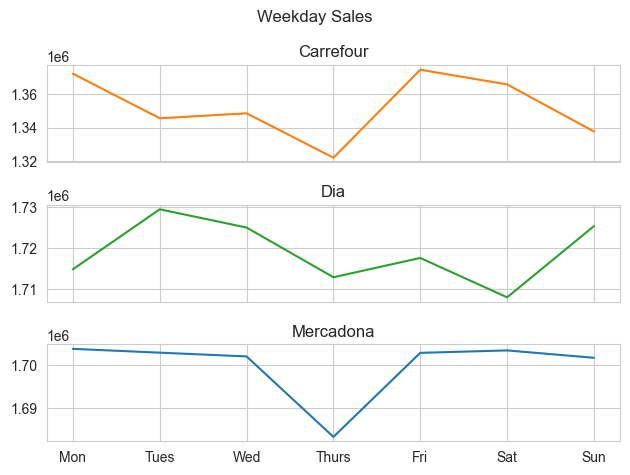

In [90]:
fig, axs= plt.subplots(3, sharex=True)
fig.suptitle('Weekday Sales')
x = by_weekday.index
axs[0].plot(x, by_weekday['Carrefour sales'], 'tab:orange')
axs[0].set_title('Carrefour')
axs[1].plot(x, by_weekday['Dia sales'],'tab:green')
axs[1].set_title('Dia')
axs[2].plot(x, by_weekday['Mercadona sales'])
axs[2].set_title('Mercadona')
fig.tight_layout();

monthly sales

In [91]:
monthlyCarre = raw_data_carre['price'].resample('M').sum()
monthlyDia = raw_data_dia['price'].resample('M').sum()
monthlyMerca = raw_data_merca['price'].resample('M').sum()
monthlyCarre

daily_sales
2021-03-31    962430.48
2021-04-30    432966.71
2021-05-31    367525.73
2021-06-30    364404.03
2021-07-31    381906.89
2021-08-31    366186.24
2021-09-30    365166.30
2021-10-31    399537.17
2021-11-30    460273.76
2021-12-31    469766.81
2022-01-31    479942.78
2022-02-28    446416.91
2022-03-31    443549.21
2022-04-30    440755.48
2022-05-31    460335.95
2022-06-30    475760.20
2022-07-31    488832.13
2022-08-31    476266.42
2022-09-30    469919.77
2022-10-31    458035.06
2022-11-30    255653.28
Freq: M, Name: price, dtype: float64

In [92]:
monthlyComparatives = pd.concat([monthlyCarre,monthlyDia,monthlyMerca], join='inner', axis=1)
monthlyComparatives.columns =['Carrefour sales', 'Dia sales', 'Mercadona sales']
monthlyComparatives = monthlyComparatives.rename_axis('monthly_sales')
monthlyComparatives

,Carrefour sales,Dia sales,Mercadona sales
monthly_sales,,,
2021-03-31,962430.48,673134.65,524837.24
2021-04-30,432966.71,615512.44,579816.26
2021-05-31,367525.73,617279.81,603101.06
2021-06-30,364404.03,590204.90,585391.99
2021-07-31,381906.89,599631.72,604384.10
2021-08-31,366186.24,519391.37,598523.70
2021-09-30,365166.30,455585.41,569412.06
2021-10-31,399537.17,485402.51,585276.54
2021-11-30,460273.76,589922.41,581745.56


<Figure size 5000x1000 with 0 Axes>

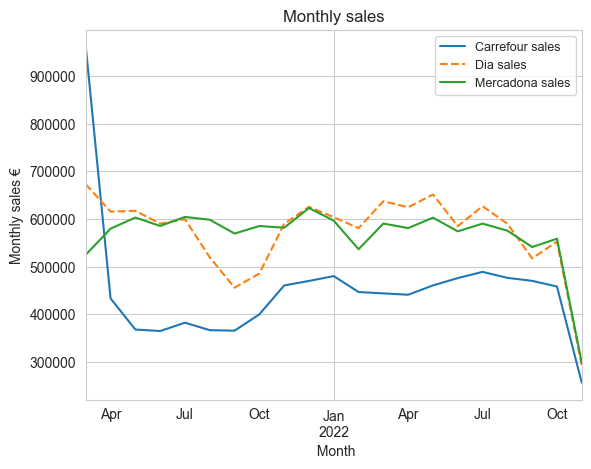

In [93]:
plt.figure(figsize=(50,10))
monthlyComparatives.plot(style=["-", '--', '-'])
plt.title("Monthly sales")
plt.legend(fontsize = '9')
plt.xlabel(" Month")
plt.ylabel("Monthly sales €");

## 5. Modeling:
Mercadona's sales volume model. The model would require more data, nevertheless, Let's try!

In [94]:
rmodelMerca.head()

,name,price,daily_sales,unit
9841,Bebida para deportistas sabor cítrico Hacendado,0.85,2021-03-05,1
9842,Bebida para deportistas sabor cítrico Hacendado,1.92,2021-03-05,1
9843,Bebida para deportistas sabor cítrico Hacendado,0.32,2021-03-05,1
9844,Bebida isotónica naranja Aquarius,1.55,2021-03-05,1
9845,Bebida isotónica naranja Aquarius,5.92,2021-03-05,1


In [95]:
#no nans
rmodelMerca.isnull().sum()

name           0
price          0
daily_sales    0
unit           0
dtype: int64

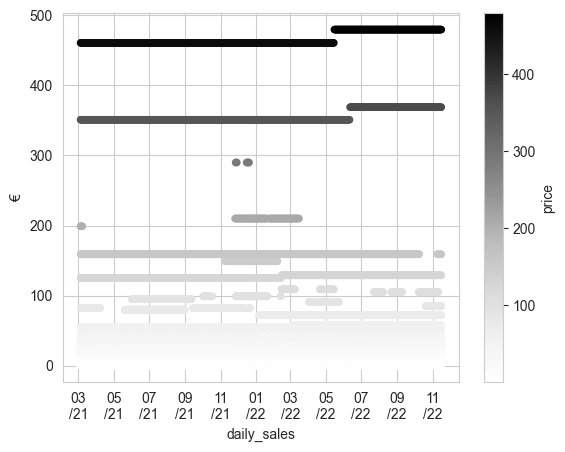

In [96]:
#outliers?
import matplotlib.dates as mdates

ax = rmodelMerca.plot(kind='scatter', x='daily_sales', y='price', c='price')
myFmt = mdates.DateFormatter('%m\n/%y')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel("€")
plt.show()

In [97]:
modelMerca2 = rmodelMerca.copy()


In [98]:
modelMerca2 = modelMerca2.groupby(['daily_sales','name']).sum()
modelMerca2['price*unit'] = modelMerca2['price']*modelMerca2['unit']
modelMerca2

price  unit  price*unit
daily_sales name                                                            
2021-03-05  1/4 Sandía                                2.60     1        2.60
            11 Panecillos                             1.00     1        1.00
            2 Baguettes para hornear Hacendado        0.75     1        0.75
            3 Baguettes masa madre                    1.15     1        1.15
            3 Barras de pan                           1.10     1        1.10
...                                                    ...   ...         ...
2022-11-16  Zumo fresh jengibre & manzana Hacendado   1.60     1        1.60
            Zumo fresh maracuyá & chía Hacendado      2.75     1        2.75
            Zumo pura naranja Hacendado               3.05     2        6.10
            Zumo pura naranja con pulpa Hacendado     1.05     1        1.05
            Ñoras Hacendado                           1.40     1        1.40

[3341423 rows x 3 columns]

In [99]:
modelMerca2 = modelMerca2.groupby(['daily_sales']).sum()

In [100]:
modelMerca2 = modelMerca2.drop(['price','unit'], axis=1)

In [101]:
modelMerca2.columns = ['Sales_volume']

In [102]:
trainMerca = modelMerca2.copy()
trainMerca.to_excel('./data/processed_data.xlsx')